[![ Click here to deploy.](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/launchable/deploy/now?launchableID=env-2rgiXa7D63Aq0bmKElJq2HpAY2x)

NOTE: it takes about 10 minutes to deploy this notebook as a Launchable. As of this writing, we are working on a free tier so a credit card may be required. You can reach out to your NVIDIA rep for credits."

# Building Generative Models for Continuous Data via Continuous Interpolants

In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.datasets import make_moons

# Task Setup

To demonstrate how Conditional Flow Matching works we use sklearn to sample from and create custom 2D distriubtions.

To start we define our "dataloader" so to speak. This is the '''sample_moons''' function.

Next we define a custom PriorDistribution to enable the conversion of 8 equidistance gaussians to the moon distribution above.



In [2]:
def sample_moons(n, normalize = False):
    x1, _ = make_moons(n_samples=n, noise=0.08)
    x1 = torch.Tensor(x1)
    x1 =  x1 * 3 - 1
    if normalize:
        x1 = (x1 - x1.mean(0))/x1.std(0) * 2
    return x1

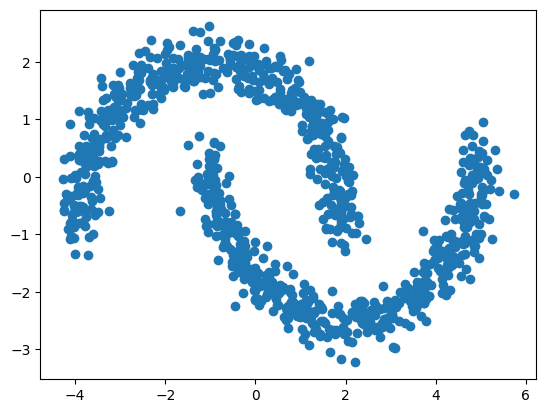

In [3]:
x1 = sample_moons(1000)
plt.scatter(x1[:, 0], x1[:, 1])

# Model Creation
Here we define a simple 4 layer MLP and define our optimizer

In [4]:
dim = 2
hidden_size = 64
batch_size = 256
model = torch.nn.Sequential(
            torch.nn.Linear(dim + 1, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, dim),
        )
optimizer = torch.optim.Adam(model.parameters())

# Continuous Flow Matching Interpolant
Here we import our desired interpolant objects.

The continuous flow matcher and the desired time distribution.

In [5]:
from bionemo.moco.interpolants import ContinuousFlowMatcher
from bionemo.moco.distributions.time import UniformTimeDistribution
from bionemo.moco.distributions.prior import GaussianPrior

uniform_time = UniformTimeDistribution()
simple_prior = GaussianPrior()
sigma = 0.1
cfm = ContinuousFlowMatcher(time_distribution=uniform_time, 
                            prior_distribution=simple_prior, 
                            sigma=sigma, 
                            prediction_type="velocity")
# Place both the model and the interpolant on the same device
DEVICE = "cuda"
model = model.to(DEVICE)
cfm = cfm.to_device(DEVICE)

# Training Loop

In [6]:
for k in range(20000):
    optimizer.zero_grad()
    shape = (batch_size, dim)
    x0 = cfm.sample_prior(shape).to(DEVICE)
    x1 = sample_moons(batch_size).to(DEVICE)

    t = cfm.sample_time(batch_size)
    xt = cfm.interpolate(x1, t, x0)
    ut = cfm.calculate_target(x1, x0)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = cfm.loss(vt, ut, target_type="velocity").mean()

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        print(f"{k+1}: loss {loss.item():0.3f}") 

5000: loss 3.156
10000: loss 2.836
15000: loss 3.035
20000: loss 3.414


# Setting Up Generation
Now we need to import the desired inference time schedule. This is what gives us the time values to iterate through to iteratively generate from our model.

Here we show the output time schedule as well as the discretization between time points. We note that different inference time schedules may have different shapes resulting in non uniform dt

In [7]:
from bionemo.moco.schedules.inference_time_schedules import LinearInferenceSchedule

inference_sched = LinearInferenceSchedule(nsteps = 100)
schedule = inference_sched.generate_schedule().to(DEVICE)
dts = inference_sched.discretize().to(DEVICE)
schedule, dts

(tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
         0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
         0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
         0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
         0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
         0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
         0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
         0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
         0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
         0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
         0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
         0.9900], device='cuda:0'),
 tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 

# Sample from the trained model

In [8]:
inf_size = 1024
sample = cfm.sample_prior((inf_size, 2)).to(DEVICE) # Start with noise
trajectory = [sample]
for dt, t in zip(dts, schedule):
    full_t = inference_sched.pad_time(inf_size, t, DEVICE)
    vt = model(torch.cat([sample, full_t[:, None]], dim=-1)) # calculate the vector field based on the definition of the model
    sample = cfm.step(vt, sample, dt, full_t)
    trajectory.append(sample) # save the trajectory for plotting purposes


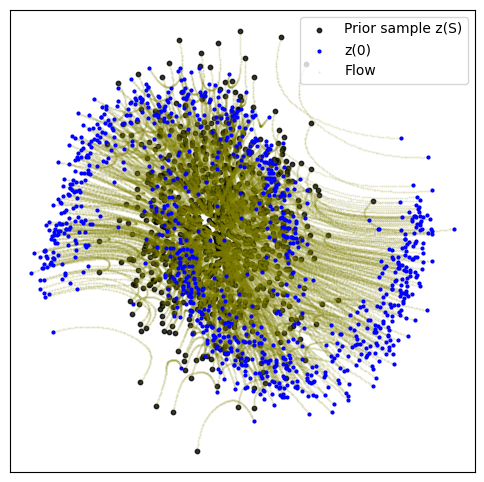

In [9]:
import matplotlib.pyplot as plt
traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024
plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label='Prior sample z(S)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0]-1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label='z(0)')

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label='Flow')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

# Sample from underlying score model

##  low temperature sampling is a heuristic, unclear what effects it has on the final distribution. Intuitively, it cuts tails and focuses more on the mode, in practice who knows exactly what's the final effect.

## gt_mode is a hyperparameter that must be experimentally chosen

In [10]:
inf_size = 1024
sample = cfm.sample_prior((inf_size, 2)).to(DEVICE)
trajectory_stoch = [sample]
vts = []
for dt, t in zip(dts, schedule):
    time  = inference_sched.pad_time(inf_size, t, DEVICE) #torch.full((inf_size,), t).to(DEVICE)
    vt = model(torch.cat([sample, time[:, None]], dim=-1))
    sample = cfm.step_score_stochastic(vt, sample, dt, time, noise_temperature=1.0, gt_mode = "tan")
    trajectory_stoch.append(sample)
    vts.append(vt)

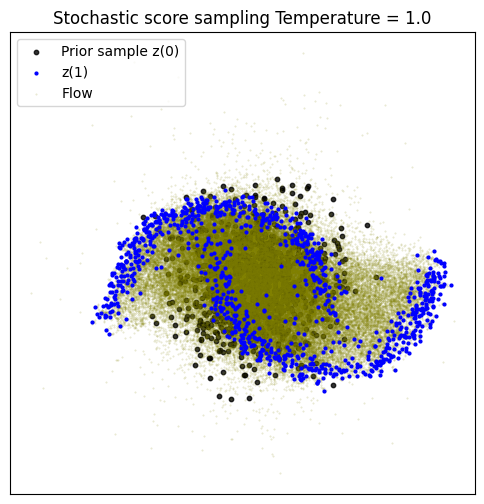

In [11]:

traj = torch.stack(trajectory_stoch).cpu().detach().numpy()
plot_limit = 1024
plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label='Prior sample z(0)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0]-1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")
# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label='z(1)')

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label='Flow')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title("Stochastic score sampling Temperature = 1.0")
plt.show()

# What happens if you just sample from a random model?

In [12]:
fmodel = torch.nn.Sequential(
            torch.nn.Linear(dim + 1, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, dim),
        ).to(DEVICE)
inf_size = 1024
sample = cfm.sample_prior((inf_size, 2)).to(DEVICE)
trajectory2 = [sample]
for dt, t in zip(dts, schedule):
    time  = inference_sched.pad_time(inf_size, t, DEVICE) #torch.full((inf_size,), t).to(DEVICE)
    vt = fmodel(torch.cat([sample, time[:, None]], dim=-1))
    sample = cfm.step(vt, sample, dt, time)
    trajectory2.append(sample)

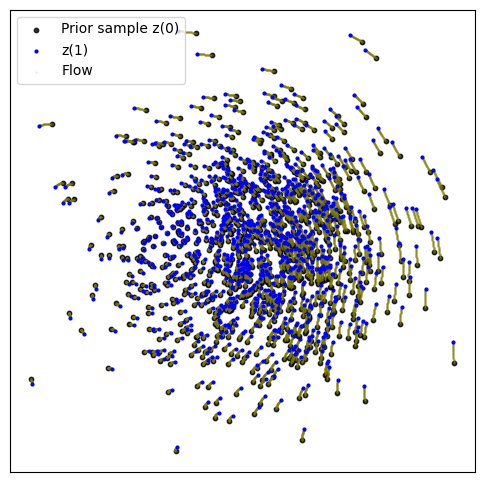

In [13]:
plot_limit = 1024
traj = torch.stack(trajectory2).cpu().detach().numpy()

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label='Prior sample z(0)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0]-1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label='z(1)')

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label='Flow')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()